# gpt4 made this

In [84]:
# import torch
# from torchvision import datasets, transforms

# # define transformation
# transform = transforms.ToTensor()

# # download and load the training data
# trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# # create a dataloader
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # download and load the test data
# testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# # create a dataloader
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# # define the network architecture
# from torch import nn, optim
# import torch.nn.functional as F

# class Classifier(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(784, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 10)
        
#     def forward(self, x):
#         # make sure input tensor is flattened
#         x = x.view(x.shape[0], -1)
        
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.log_softmax(self.fc4(x), dim=1)
        
#         return x
    
# model = Classifier()

# # define the loss
# criterion = nn.NLLLoss()

# # define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.003)

# # train the network
# epochs = 5

# for e in range(epochs):
#     running_loss = 0
#     for images, labels in trainloader:
#         # clear the gradients
#         optimizer.zero_grad()
        
#         # forward pass
#         output = model(images)
#         loss = criterion(output, labels)
        
#         # backward pass
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#     else:
#         print(f"Training loss: {running_loss/len(trainloader)}")

# # test the network
# correct = 0
# total = 0

# with torch.no_grad():
#     for images, labels in testloader:
#         output = model(images)
#         _, predicted = torch.max(output, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy: {100 * correct / total}%")


# ### 2.2.2. Saving and loading models

# # save the model
# torch.save(model.state_dict(), 'checkpoint.pth')

# # load the model
# state_dict = torch.load('checkpoint.pth')
# print(state_dict.keys())

# model.load_state_dict(state_dict)

# # continue training
# model = Classifier()
# model.load_state_dict(state_dict)

# # continue training
# optimizer = optim.Adam(model.parameters(), lr=0.003)

# epochs = 1

# for e in range(epochs):
#     running_loss = 0
#     for images, labels in trainloader:
#         optimizer.zero_grad()
#         output = model(images)
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     else:
#         print(f"Training loss: {running_loss/len(trainloader)}")


# ### 2.2.3. Loading image data


# Denselayer

In [85]:
import numpy as np

class DenseLayer:
    def __init__(self, input_dim, output_dim, gradient_clip_value=None):
        """
        Initialize a dense (fully connected) layer with given input and output dimensions.
        
        Parameters:
        - input_dim: int, number of input features
        - output_dim: int, number of output units
        - gradient_clip_value: float or None, maximum absolute value for gradients (if clipping is desired)
        """
        # Xavier/Glorot initialization for weights
        limit = np.sqrt(6 / (input_dim + output_dim))
        self.weights = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.biases = np.zeros((1, output_dim))
        
        # Placeholder for gradients
        self.d_weights = None
        self.d_biases = None
        
        # Gradient clipping threshold
        self.gradient_clip_value = gradient_clip_value

    def forward(self, X):
        """
        Perform the forward pass through the dense layer.
        
        Parameters:
        - X: ndarray, input data of shape (batch_size, input_dim)
        
        Returns:
        - output: ndarray, result of the layer transformation, shape (batch_size, output_dim)
        """
        self.input = X
        self.output = np.dot(X, self.weights) + self.biases
        return self.output

    def backward(self, d_out):
        """
        Compute the gradients of weights and biases with respect to the loss.
        
        Parameters:
        - d_out: ndarray, gradient of the loss with respect to the output of this layer, 
        shape (batch_size, output_dim)
        
        Returns:
        - d_input: ndarray, gradient of the loss with respect to the input of this layer, shape (batch_size, input_dim)
        """
        # Gradient of the loss with respect to weights and biases
        self.d_weights = np.dot(self.input.T, d_out)
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)
        
        # Gradient of the loss with respect to the input of this layer
        d_input = np.dot(d_out, self.weights.T)
        
        # Clip gradients if gradient clipping is enabled
        if self.gradient_clip_value is not None:
            np.clip(self.d_weights, -self.gradient_clip_value, self.gradient_clip_value, out=self.d_weights)
            np.clip(self.d_biases, -self.gradient_clip_value, self.gradient_clip_value, out=self.d_biases)
        
        return d_input




# Adam Optimizer

In [86]:
class AdamOptimizer:
    def __init__(self, layer, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.layer = layer
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Initialize moment estimates
        if hasattr(layer, 'weights'):
            # For DenseLayer
            self.m_weights = np.zeros_like(layer.weights)
            self.v_weights = np.zeros_like(layer.weights)
            self.m_biases = np.zeros_like(layer.biases)
            self.v_biases = np.zeros_like(layer.biases)
        elif hasattr(layer, 'gamma'):
            # For BatchNormalization
            self.m_gamma = np.zeros_like(layer.gamma)
            self.v_gamma = np.zeros_like(layer.gamma)
            self.m_beta = np.zeros_like(layer.beta)
            self.v_beta = np.zeros_like(layer.beta)

        # Time step for bias correction
        self.t = 1

    def update(self):
        if hasattr(self.layer, 'weights'):
            # Update DenseLayer weights and biases
            self._update_dense()
        elif hasattr(self.layer, 'gamma'):
            # Update BatchNormalization gamma and beta
            self._update_batch_norm()

        # Increment time step
        self.t += 1

    def _update_dense(self):
        # Adam update for weights
        self.m_weights = self.beta1 * self.m_weights + (1 - self.beta1) * self.layer.d_weights
        self.v_weights = self.beta2 * self.v_weights + (1 - self.beta2) * (self.layer.d_weights ** 2)
        m_weights_corr = self.m_weights / (1 - self.beta1 ** self.t)
        v_weights_corr = self.v_weights / (1 - self.beta2 ** self.t)
        self.layer.weights -= self.learning_rate * m_weights_corr / (np.sqrt(v_weights_corr) + self.epsilon)
        
        # Adam update for biases
        self.m_biases = self.beta1 * self.m_biases + (1 - self.beta1) * self.layer.d_biases
        self.v_biases = self.beta2 * self.v_biases + (1 - self.beta2) * (self.layer.d_biases ** 2)
        m_biases_corr = self.m_biases / (1 - self.beta1 ** self.t)
        v_biases_corr = self.v_biases / (1 - self.beta2 ** self.t)
        self.layer.biases -= self.learning_rate * m_biases_corr / (np.sqrt(v_biases_corr) + self.epsilon)

    def _update_batch_norm(self):
        # Adam update for gamma
        self.m_gamma = self.beta1 * self.m_gamma + (1 - self.beta1) * self.layer.d_gamma
        self.v_gamma = self.beta2 * self.v_gamma + (1 - self.beta2) * (self.layer.d_gamma ** 2)
        m_gamma_corr = self.m_gamma / (1 - self.beta1 ** self.t)
        v_gamma_corr = self.v_gamma / (1 - self.beta2 ** self.t)
        self.layer.gamma -= self.learning_rate * m_gamma_corr / (np.sqrt(v_gamma_corr) + self.epsilon)
        
        # Adam update for beta
        self.m_beta = self.beta1 * self.m_beta + (1 - self.beta1) * self.layer.d_beta
        self.v_beta = self.beta2 * self.v_beta + (1 - self.beta2) * (self.layer.d_beta ** 2)
        m_beta_corr = self.m_beta / (1 - self.beta1 ** self.t)
        v_beta_corr = self.v_beta / (1 - self.beta2 ** self.t)
        self.layer.beta -= self.learning_rate * m_beta_corr / (np.sqrt(v_beta_corr) + self.epsilon)


# Batch Normalization

In [87]:
class BatchNormalization:
    def __init__(self, dim, momentum=0.9, epsilon=1e-5):
        """
        Initialize the Batch Normalization layer.
        
        Parameters:
        - dim: int, number of features in the input
        - momentum: float, momentum for moving average of mean and variance
        - epsilon: float, small constant to prevent division by zero
        """
        self.momentum = momentum
        self.epsilon = epsilon
        self.gamma = np.ones((1, dim))  # Scale parameter
        self.beta = np.zeros((1, dim))  # Shift parameter
        self.running_mean = np.zeros((1, dim))
        self.running_var = np.ones((1, dim))
        self.training = True

    def forward(self, X):
        """
        Forward pass for Batch Normalization.
        
        Parameters:
        - X: ndarray, input data of shape (batch_size, dim)
        
        Returns:
        - out: ndarray, normalized and scaled output
        """
        if self.training:
            # Compute mean and variance for the batch
            batch_mean = np.mean(X, axis=0, keepdims=True)
            batch_var = np.var(X, axis=0, keepdims=True)
            
            # Normalize
            self.X_centered = X - batch_mean
            self.stddev_inv = 1.0 / np.sqrt(batch_var + self.epsilon)
            X_norm = self.X_centered * self.stddev_inv
            
            # Update running mean and variance for inference
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
        else:
            # Use running mean and variance for inference
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
        
        # Scale and shift
        out = self.gamma * X_norm + self.beta
        self.X_norm = X_norm  # Store for backward pass
        return out

    def backward(self, d_out, learning_rate):
        """
        Backward pass for Batch Normalization.
        
        Parameters:
        - d_out: ndarray, gradient of the loss with respect to the output of this layer
        - learning_rate: float, learning rate for parameter updates
        
        Returns:
        - d_input: ndarray, gradient of the loss with respect to the input of this layer
        """
        # Gradients with respect to gamma and beta
        self.d_gamma = np.sum(d_out * self.X_norm, axis=0, keepdims=True)
        self.d_beta = np.sum(d_out, axis=0, keepdims=True)
        
        # Gradient with respect to normalized input
        d_X_norm = d_out * self.gamma
        
        # Gradient with respect to variance
        d_var = np.sum(d_X_norm * self.X_centered, axis=0, keepdims=True) * -0.5 * self.stddev_inv**3
        
        # Gradient with respect to mean
        d_mean = np.sum(d_X_norm * -self.stddev_inv, axis=0, keepdims=True) + d_var * np.mean(-2.0 * self.X_centered, axis=0, keepdims=True)
        
        # Gradient with respect to input
        d_input = (d_X_norm * self.stddev_inv) + (d_var * 2 * self.X_centered / d_out.shape[0]) + (d_mean / d_out.shape[0])
        
        # Update parameters
        self.gamma -= learning_rate * self.d_gamma
        self.beta -= learning_rate * self.d_beta
        
        return d_input

    def set_training_mode(self, mode=True):
        """
        Set the layer in training or evaluation mode.
        
        Parameters:
        - mode: bool, True for training mode, False for evaluation mode
        """
        self.training = mode


# Activation: ReLU

In [88]:
class ReLU:
    def __init__(self):
        # Placeholder to store input for the backward pass
        self.input = None
        self.d_input = None

    def forward(self, X):
        """
        Perform the forward pass of the ReLU activation.
        
        Parameters:
        - X: ndarray, input data of shape (batch_size, input_dim)
        
        Returns:
        - output: ndarray, output after ReLU activation
        """
        self.input = X
        # Apply ReLU activation: ReLU(x) = max(0, x)
        return np.maximum(0, X)

    def backward(self, d_out):
        """
        Perform the backward pass of the ReLU activation.
        
        Parameters:
        - d_out: ndarray, gradient of the loss with respect to the output of the ReLU
        
        Returns:
        - d_input: ndarray, gradient of the loss with respect to the input of the ReLU
        """
        # The derivative of ReLU is 1 where input > 0 and 0 where input <= 0
        self.d_input = d_out * (self.input > 0)  # Element-wise multiplication with mask
        return self.d_input


# Regularization: Dropout

In [89]:
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.training = True

    def set_training_mode(self, mode=True):
        """
        Set the dropout layer to training mode (drop units) or testing mode (no dropout).
        
        Parameters:
        - mode: bool, True for training mode, False for testing mode.
        """
        self.training = mode

    def forward(self, X):
        """
        Apply dropout during the forward pass.
        
        Parameters:
        - X: ndarray, input data
        
        Returns:
        - output: ndarray, with dropout applied if in training mode
        """
        if self.training:
            mask = (np.random.rand(*X.shape) > self.dropout_rate).astype(np.float32)
            self.mask = mask / (1 - self.dropout_rate)
            return X * self.mask
        else:
            return X

    def backward(self, d_out):
        """
        Backward pass for dropout, scaled by the mask created in the forward pass.
        
        Parameters:
        - d_out: ndarray, gradient of loss w.r.t dropout layer output
        
        Returns:
        - d_input: ndarray, gradient of loss w.r.t dropout layer input
        """
        return d_out * self.mask if self.training else d_out


# Testing Dense Layer + Batch NOrmalization(83%) + ReLU(77%) + Dropout 83.87%

### lower learning rate, reordered layers, and dropout rate 

# RUNNABLE

Epoch 1/30, Train Loss: 2.0474, Train Acc: 31.37%, Val Loss: 1.1562, Val Acc: 76.47%, Val Macro-F1: 0.7642
Epoch 2/30, Train Loss: 1.6948, Train Acc: 40.01%, Val Loss: 1.0538, Val Acc: 79.03%, Val Macro-F1: 0.7899
Epoch 3/30, Train Loss: 1.5963, Train Acc: 42.33%, Val Loss: 0.9981, Val Acc: 80.62%, Val Macro-F1: 0.8061
Epoch 4/30, Train Loss: 1.5359, Train Acc: 44.14%, Val Loss: 0.9477, Val Acc: 81.47%, Val Macro-F1: 0.8156
Epoch 5/30, Train Loss: 1.5002, Train Acc: 44.71%, Val Loss: 0.9280, Val Acc: 82.72%, Val Macro-F1: 0.8275
Epoch 6/30, Train Loss: 1.4612, Train Acc: 45.92%, Val Loss: 0.8858, Val Acc: 83.30%, Val Macro-F1: 0.8333
Epoch 7/30, Train Loss: 1.4352, Train Acc: 46.55%, Val Loss: 0.8580, Val Acc: 83.80%, Val Macro-F1: 0.8394
Epoch 8/30, Train Loss: 1.4029, Train Acc: 47.64%, Val Loss: 0.8188, Val Acc: 84.18%, Val Macro-F1: 0.8414
Epoch 9/30, Train Loss: 1.3976, Train Acc: 47.15%, Val Loss: 0.8172, Val Acc: 84.52%, Val Macro-F1: 0.8463
Epoch 10/30, Train Loss: 1.3830, Trai

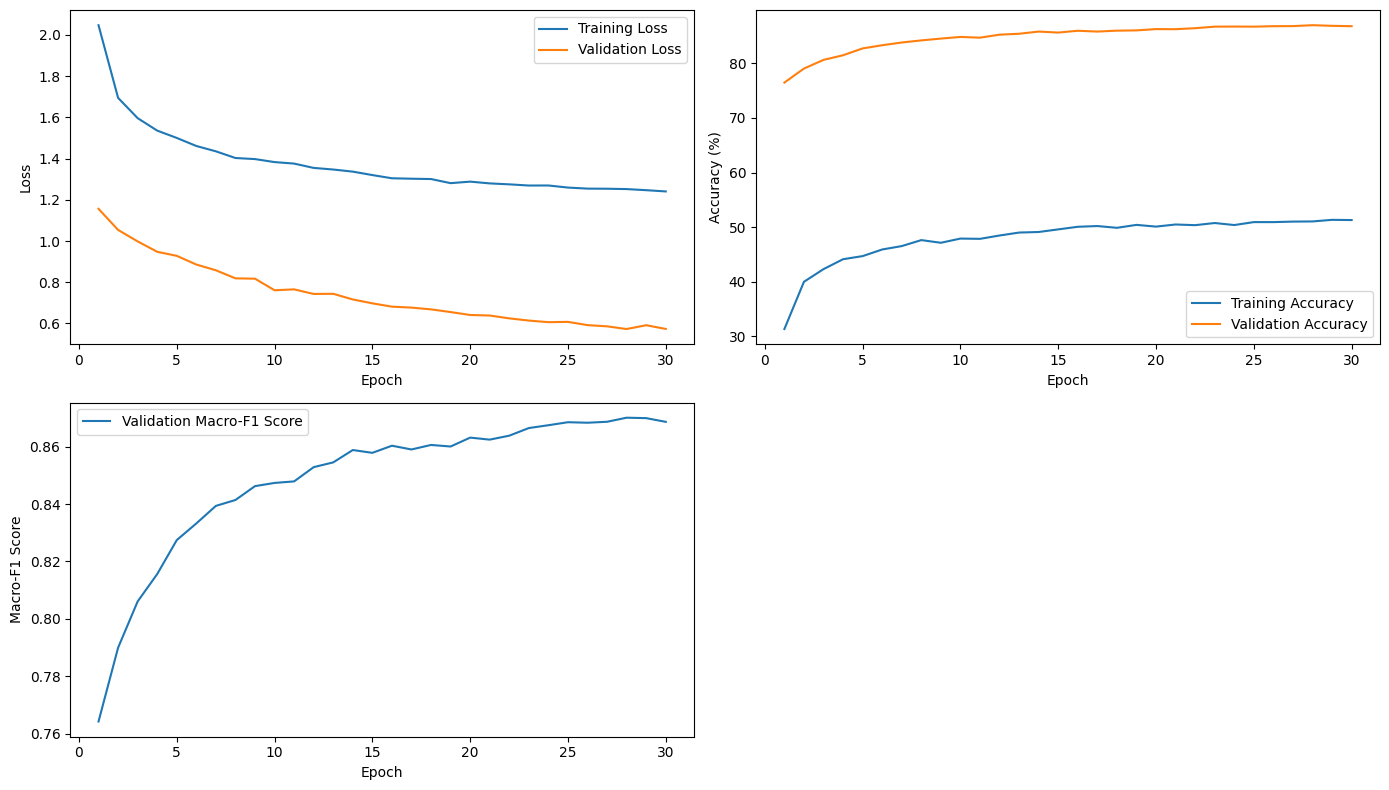

In [ ]:
import pickle

import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

with open('b1.pkl', 'rb') as b1:
  testset = pickle.load(b1)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.0001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Output layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=output_dim)
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout3 = dropout3.backward(d_out)
            d_bn3 = batch_norm3.backward(d_dropout3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_dropout3 = dropout3.forward(outputs_bn3)

                exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=30)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            predicted = np.argmax(outputs_dropout3, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 30 epochs
epochs_range = range(1, 31)  # Now covers 1 to 30 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


# 1 hidden layer

## 0.001

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu = ReLU()  # Adding ReLU activation for hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for hidden layer

dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=output_dim)
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and a hidden layer
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu = relu.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_dropout2 = dropout2.forward(outputs_bn2)

            exp_outputs = np.exp(outputs_dropout2 - np.max(outputs_dropout2, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout2 = dropout2.backward(d_out)
            d_bn2 = batch_norm2.backward(d_dropout2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu = relu.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu = relu.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_dropout2 = dropout2.forward(outputs_bn2)

                exp_outputs = np.exp(outputs_dropout2 - np.max(outputs_dropout2, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu = relu.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_dropout2 = dropout2.forward(outputs_bn2)

            predicted = np.argmax(outputs_dropout2, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## 0.0001

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.0001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu = ReLU()  # Adding ReLU activation for hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for hidden layer

dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=output_dim)
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and a hidden layer
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu = relu.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_dropout2 = dropout2.forward(outputs_bn2)

            exp_outputs = np.exp(outputs_dropout2 - np.max(outputs_dropout2, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout2 = dropout2.backward(d_out)
            d_bn2 = batch_norm2.backward(d_dropout2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu = relu.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu = relu.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_dropout2 = dropout2.forward(outputs_bn2)

                exp_outputs = np.exp(outputs_dropout2 - np.max(outputs_dropout2, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu = relu.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_dropout2 = dropout2.forward(outputs_bn2)

            predicted = np.argmax(outputs_dropout2, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## 0.01

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.01

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu = ReLU()  # Adding ReLU activation for hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for hidden layer

dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=output_dim)
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and a hidden layer
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu = relu.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_dropout2 = dropout2.forward(outputs_bn2)

            exp_outputs = np.exp(outputs_dropout2 - np.max(outputs_dropout2, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout2 = dropout2.backward(d_out)
            d_bn2 = batch_norm2.backward(d_dropout2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu = relu.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu = relu.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_dropout2 = dropout2.forward(outputs_bn2)

                exp_outputs = np.exp(outputs_dropout2 - np.max(outputs_dropout2, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu = relu.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_dropout2 = dropout2.forward(outputs_bn2)

            predicted = np.argmax(outputs_dropout2, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


# 2 hidden layer

## 0.001

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Output layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=output_dim)
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout3 = dropout3.backward(d_out)
            d_bn3 = batch_norm3.backward(d_dropout3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_dropout3 = dropout3.forward(outputs_bn3)

                exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            predicted = np.argmax(outputs_dropout3, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## 0.0001

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.0001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Output layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=output_dim)
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout3 = dropout3.backward(d_out)
            d_bn3 = batch_norm3.backward(d_dropout3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_dropout3 = dropout3.forward(outputs_bn3)

                exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            predicted = np.argmax(outputs_dropout3, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## 0.01

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.01

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Output layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=output_dim)
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout3 = dropout3.backward(d_out)
            d_bn3 = batch_norm3.backward(d_dropout3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_dropout3 = dropout3.forward(outputs_bn3)

                exp_outputs = np.exp(outputs_dropout3 - np.max(outputs_dropout3, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_dropout3 = dropout3.forward(outputs_bn3)

            predicted = np.argmax(outputs_dropout3, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


# 3 Hidden Layer

## 0.001

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Third hidden layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=hidden_dim)
relu3 = ReLU()  # Adding ReLU activation for third hidden layer
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for third hidden layer

# Output layer
dense_layer4 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm4 = BatchNormalization(dim=output_dim)
dropout4 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

optimizer_dense4 = AdamOptimizer(dense_layer4, learning_rate=learning_rate)
optimizer_bn4 = AdamOptimizer(batch_norm4, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        batch_norm4.set_training_mode(True)
        dropout4.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_relu3 = relu3.forward(outputs_bn3)
            outputs_dropout3 = dropout3.forward(outputs_relu3)

            outputs_dense4 = dense_layer4.forward(outputs_dropout3)
            outputs_bn4 = batch_norm4.forward(outputs_dense4)
            outputs_dropout4 = dropout4.forward(outputs_bn4)

            exp_outputs = np.exp(outputs_dropout4 - np.max(outputs_dropout4, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout4 = dropout4.backward(d_out)
            d_bn4 = batch_norm4.backward(d_dropout4, learning_rate)
            d_dense4 = dense_layer4.backward(d_bn4)

            d_dropout3 = dropout3.backward(d_dense4)
            d_relu3 = relu3.backward(d_dropout3)
            d_bn3 = batch_norm3.backward(d_relu3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()
            optimizer_dense4.update()
            optimizer_bn4.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)
        batch_norm4.set_training_mode(False)
        dropout4.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_relu3 = relu3.forward(outputs_bn3)
                outputs_dropout3 = dropout3.forward(outputs_relu3)

                outputs_dense4 = dense_layer4.forward(outputs_dropout3)
                outputs_bn4 = batch_norm4.forward(outputs_dense4)
                outputs_dropout4 = dropout4.forward(outputs_bn4)

                exp_outputs = np.exp(outputs_dropout4 - np.max(outputs_dropout4, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)
    batch_norm4.set_training_mode(False)
    dropout4.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_relu3 = relu3.forward(outputs_bn3)
            outputs_dropout3 = dropout3.forward(outputs_relu3)

            outputs_dense4 = dense_layer4.forward(outputs_dropout3)
            outputs_bn4 = batch_norm4.forward(outputs_dense4)
            outputs_dropout4 = dropout4.forward(outputs_bn4)

            predicted = np.argmax(outputs_dropout4, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## 0.0001


In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.0001

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Third hidden layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=hidden_dim)
relu3 = ReLU()  # Adding ReLU activation for third hidden layer
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for third hidden layer

# Output layer
dense_layer4 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm4 = BatchNormalization(dim=output_dim)
dropout4 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

optimizer_dense4 = AdamOptimizer(dense_layer4, learning_rate=learning_rate)
optimizer_bn4 = AdamOptimizer(batch_norm4, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        batch_norm4.set_training_mode(True)
        dropout4.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_relu3 = relu3.forward(outputs_bn3)
            outputs_dropout3 = dropout3.forward(outputs_relu3)

            outputs_dense4 = dense_layer4.forward(outputs_dropout3)
            outputs_bn4 = batch_norm4.forward(outputs_dense4)
            outputs_dropout4 = dropout4.forward(outputs_bn4)

            exp_outputs = np.exp(outputs_dropout4 - np.max(outputs_dropout4, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout4 = dropout4.backward(d_out)
            d_bn4 = batch_norm4.backward(d_dropout4, learning_rate)
            d_dense4 = dense_layer4.backward(d_bn4)

            d_dropout3 = dropout3.backward(d_dense4)
            d_relu3 = relu3.backward(d_dropout3)
            d_bn3 = batch_norm3.backward(d_relu3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()
            optimizer_dense4.update()
            optimizer_bn4.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)
        batch_norm4.set_training_mode(False)
        dropout4.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_relu3 = relu3.forward(outputs_bn3)
                outputs_dropout3 = dropout3.forward(outputs_relu3)

                outputs_dense4 = dense_layer4.forward(outputs_dropout3)
                outputs_bn4 = batch_norm4.forward(outputs_dense4)
                outputs_dropout4 = dropout4.forward(outputs_bn4)

                exp_outputs = np.exp(outputs_dropout4 - np.max(outputs_dropout4, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)
    batch_norm4.set_training_mode(False)
    dropout4.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_relu3 = relu3.forward(outputs_bn3)
            outputs_dropout3 = dropout3.forward(outputs_relu3)

            outputs_dense4 = dense_layer4.forward(outputs_dropout3)
            outputs_bn4 = batch_norm4.forward(outputs_dense4)
            outputs_dropout4 = dropout4.forward(outputs_bn4)

            predicted = np.argmax(outputs_dropout4, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


## 0.01

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Define the DenseLayer, BatchNormalization, ReLU, Dropout, and AdamOptimizer classes as discussed above

# Define transformations and load the dataset
transform = transforms.ToTensor()

# Load training and test data
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

# Split trainset into training and validation sets (e.g., 90% train, 10% validation)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Set up data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize model layers and optimizers
input_dim = 28 * 28  # FashionMNIST images are 28x28
hidden_dim = 128     # Hidden layer dimension
output_dim = 10      # 10 classes for classification
learning_rate = 0.01

# Define the layers
dense_layer1 = DenseLayer(input_dim=input_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm1 = BatchNormalization(dim=hidden_dim)
relu1 = ReLU()  # Adding ReLU activation for first hidden layer
dropout1 = Dropout(dropout_rate=0.5)  # Dropout for first hidden layer

# Second hidden layer
dense_layer2 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm2 = BatchNormalization(dim=hidden_dim)
relu2 = ReLU()  # Adding ReLU activation for second hidden layer
dropout2 = Dropout(dropout_rate=0.5)  # Dropout for second hidden layer

# Third hidden layer
dense_layer3 = DenseLayer(input_dim=hidden_dim, output_dim=hidden_dim, gradient_clip_value=1.0)
batch_norm3 = BatchNormalization(dim=hidden_dim)
relu3 = ReLU()  # Adding ReLU activation for third hidden layer
dropout3 = Dropout(dropout_rate=0.5)  # Dropout for third hidden layer

# Output layer
dense_layer4 = DenseLayer(input_dim=hidden_dim, output_dim=output_dim, gradient_clip_value=1.0)
batch_norm4 = BatchNormalization(dim=output_dim)
dropout4 = Dropout(dropout_rate=0.5)  # Dropout for output layer

# Define the optimizers for each layer
optimizer_dense1 = AdamOptimizer(dense_layer1, learning_rate=learning_rate)
optimizer_bn1 = AdamOptimizer(batch_norm1, learning_rate=learning_rate)

optimizer_dense2 = AdamOptimizer(dense_layer2, learning_rate=learning_rate)
optimizer_bn2 = AdamOptimizer(batch_norm2, learning_rate=learning_rate)

optimizer_dense3 = AdamOptimizer(dense_layer3, learning_rate=learning_rate)
optimizer_bn3 = AdamOptimizer(batch_norm3, learning_rate=learning_rate)

optimizer_dense4 = AdamOptimizer(dense_layer4, learning_rate=learning_rate)
optimizer_bn4 = AdamOptimizer(batch_norm4, learning_rate=learning_rate)

# Define metrics storage for visualization
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_macro_f1s = []

# Define a training function with Batch Normalization, Dropout, and hidden layers
def train(epochs):
    for epoch in range(epochs):
        # Set training mode
        batch_norm1.set_training_mode(True)
        dropout1.set_training_mode(True)
        batch_norm2.set_training_mode(True)
        dropout2.set_training_mode(True)
        batch_norm3.set_training_mode(True)
        dropout3.set_training_mode(True)
        batch_norm4.set_training_mode(True)
        dropout4.set_training_mode(True)
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        
        # Training phase
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1).numpy()  # Flatten images

            # Forward pass
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_relu3 = relu3.forward(outputs_bn3)
            outputs_dropout3 = dropout3.forward(outputs_relu3)

            outputs_dense4 = dense_layer4.forward(outputs_dropout3)
            outputs_bn4 = batch_norm4.forward(outputs_dense4)
            outputs_dropout4 = dropout4.forward(outputs_bn4)

            exp_outputs = np.exp(outputs_dropout4 - np.max(outputs_dropout4, axis=1, keepdims=True))
            probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

            one_hot_labels = np.eye(output_dim)[labels.numpy()]
            loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
            total_train_loss += loss

            # Backpropagation
            d_out = (probs - one_hot_labels) / labels.shape[0]
            d_dropout4 = dropout4.backward(d_out)
            d_bn4 = batch_norm4.backward(d_dropout4, learning_rate)
            d_dense4 = dense_layer4.backward(d_bn4)

            d_dropout3 = dropout3.backward(d_dense4)
            d_relu3 = relu3.backward(d_dropout3)
            d_bn3 = batch_norm3.backward(d_relu3, learning_rate)
            d_dense3 = dense_layer3.backward(d_bn3)

            d_dropout2 = dropout2.backward(d_dense3)
            d_relu2 = relu2.backward(d_dropout2)
            d_bn2 = batch_norm2.backward(d_relu2, learning_rate)
            d_dense2 = dense_layer2.backward(d_bn2)

            d_dropout1 = dropout1.backward(d_dense2)
            d_relu1 = relu1.backward(d_dropout1)
            d_bn1 = batch_norm1.backward(d_relu1, learning_rate)
            dense_layer1.backward(d_bn1)

            # Update weights
            optimizer_dense1.update()
            optimizer_bn1.update()
            optimizer_dense2.update()
            optimizer_bn2.update()
            optimizer_dense3.update()
            optimizer_bn3.update()
            optimizer_dense4.update()
            optimizer_bn4.update()

            # Accuracy calculation
            predicted = np.argmax(probs, axis=1)
            total_train_correct += np.sum(predicted == labels.numpy())
            total_train_samples += labels.shape[0]

        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(total_train_loss / len(trainloader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        batch_norm1.set_training_mode(False)
        dropout1.set_training_mode(False)
        batch_norm2.set_training_mode(False)
        dropout2.set_training_mode(False)
        batch_norm3.set_training_mode(False)
        dropout3.set_training_mode(False)
        batch_norm4.set_training_mode(False)
        dropout4.set_training_mode(False)

        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(images.shape[0], -1).numpy()
                
                # Forward pass for validation
                outputs_dense1 = dense_layer1.forward(images)
                outputs_bn1 = batch_norm1.forward(outputs_dense1)
                outputs_relu1 = relu1.forward(outputs_bn1)
                outputs_dropout1 = dropout1.forward(outputs_relu1)

                outputs_dense2 = dense_layer2.forward(outputs_dropout1)
                outputs_bn2 = batch_norm2.forward(outputs_dense2)
                outputs_relu2 = relu2.forward(outputs_bn2)
                outputs_dropout2 = dropout2.forward(outputs_relu2)

                outputs_dense3 = dense_layer3.forward(outputs_dropout2)
                outputs_bn3 = batch_norm3.forward(outputs_dense3)
                outputs_relu3 = relu3.forward(outputs_bn3)
                outputs_dropout3 = dropout3.forward(outputs_relu3)

                outputs_dense4 = dense_layer4.forward(outputs_dropout3)
                outputs_bn4 = batch_norm4.forward(outputs_dense4)
                outputs_dropout4 = dropout4.forward(outputs_bn4)

                exp_outputs = np.exp(outputs_dropout4 - np.max(outputs_dropout4, axis=1, keepdims=True))
                probs = exp_outputs / np.sum(exp_outputs, axis=1, keepdims=True)

                one_hot_labels = np.eye(output_dim)[labels.numpy()]
                loss = -np.sum(one_hot_labels * np.log(probs + 1e-8)) / labels.shape[0]
                val_loss += loss

                predicted = np.argmax(probs, axis=1)
                val_correct += np.sum(predicted == labels.numpy())
                val_total += labels.size(0)
                all_preds.extend(predicted)
                all_labels.extend(labels.numpy())

        val_accuracy = 100 * val_correct / val_total
        val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(val_accuracy)
        val_macro_f1s.append(val_macro_f1)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%, Val Macro-F1: {val_macro_f1s[-1]:.4f}")

# Train the model
train(epochs=100)

# Test function to evaluate on the test set
def test():
    correct = 0
    total = 0

    batch_norm1.set_training_mode(False)
    dropout1.set_training_mode(False)
    batch_norm2.set_training_mode(False)
    dropout2.set_training_mode(False)
    batch_norm3.set_training_mode(False)
    dropout3.set_training_mode(False)
    batch_norm4.set_training_mode(False)
    dropout4.set_training_mode(False)

    with torch.no_grad():
        for images, labels in testloader:
            images = images.view(images.shape[0], -1).numpy()

            # Forward pass for testing
            outputs_dense1 = dense_layer1.forward(images)
            outputs_bn1 = batch_norm1.forward(outputs_dense1)
            outputs_relu1 = relu1.forward(outputs_bn1)
            outputs_dropout1 = dropout1.forward(outputs_relu1)

            outputs_dense2 = dense_layer2.forward(outputs_dropout1)
            outputs_bn2 = batch_norm2.forward(outputs_dense2)
            outputs_relu2 = relu2.forward(outputs_bn2)
            outputs_dropout2 = dropout2.forward(outputs_relu2)

            outputs_dense3 = dense_layer3.forward(outputs_dropout2)
            outputs_bn3 = batch_norm3.forward(outputs_dense3)
            outputs_relu3 = relu3.forward(outputs_bn3)
            outputs_dropout3 = dropout3.forward(outputs_relu3)

            outputs_dense4 = dense_layer4.forward(outputs_dropout3)
            outputs_bn4 = batch_norm4.forward(outputs_dense4)
            outputs_dropout4 = dropout4.forward(outputs_bn4)

            predicted = np.argmax(outputs_dropout4, axis=1)
            correct += np.sum(predicted == labels.numpy())
            total += labels.size(0)

    print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test()

# Plotting the metrics for 100 epochs
epochs_range = range(1, 101)  # Now covers 1 to 100 epochs
plt.figure(figsize=(14, 8))   # Optional: Increase figure width if desired

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot validation macro-F1 score
plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_macro_f1s, label="Validation Macro-F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Macro-F1 Score")
plt.legend()

plt.tight_layout()
plt.show()
